In [90]:
from kaleido.scopes.plotly import PlotlyScope
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import numpy as np
import pandas as pd
import sounddevice as sd
import helpers as hp
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
import librosa
import librosa.feature
from feature_extraction import pytorch_models as tm
import optuna
import torch
SR = 44100
import imp
import joblib
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
drum_names = ['hat', 'kick', 'shake', 'snare']
optuna.logging.set_verbosity(0)


icy = ['rgb(0,0,0)','rgb(50,50,140)','rgb(70,70,160)','rgb(110,110,200)','rgb(130,130,210)',
     'rgb(150,150,230)', 'rgb(170,170,255)','rgb(190,190,255)',
     'rgb(200,200,255)','rgb(210,210,255)','rgb(220,220,255)','rgb(240,240,255)']
icy_r = icy.copy()
icy_r.reverse()
imp.reload(tm)
# let's sample from the probability distribution
dt = 1
study_name = "HyperBand_%s"%drum_names[dt]
study = joblib.load("studies/%s_study.pkl"%study_name)

In [9]:
cnet_dvn = tm.Transformer_DVN(attention_dropout=0.3,d_model=120,heads=30,encoding_layers=12,pool_dim=2,)
cnet_dvn = cnet_dvn.load_from_checkpoint(
    "models/transformer/DVNepoch=41-val_accuracy=0.991-val_loss=0.048.ckpt")

cnet_dvd = tm.Transformer_DVD(attention_dropout=0.3,d_model=100,heads=20,encoding_layers=12,pool_dim=1,pct_start=0.05,max_lr=1e-4,max_momentum=0.95,epochs=50)
cnet_dvd = cnet_dvd.load_from_checkpoint(
    "models/transformer/DVDepoch=59-val_accuracy=0.917-val_auc=0.9779-val_loss=0.327.ckpt")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
cnet_dvn.to(device)
cnet_dvd.to(device)
pass 

In [94]:
space = optuna.samplers.intersection_search_space(study)
num_invalids = 0
for i in range(100):
    try:
        print(i,end="\r")
        params = study.sampler.sample_relative(study,optuna.trial._frozen.FrozenTrial,space)
        program = pg.StackParams()
        program.__dict__ = dict(zip(program.__dict__.keys(),params.values()))
        out = dsp.buffer(length=1,channels=1)
        s = pg.Synth(program)
        out.dub(s.buff,program.getStart())
        out = fx.norm(out,1)
        sound = hp.memToAud(out)
        
        signal = torch.tensor(librosa.resample(sound.reshape(-1),SR,SR//2)).to(device)[0:SR//4].reshape(1,-1)
        cnet_dvn.eval(),cnet_dvd.eval()
        with torch.no_grad():
            score_dvn = cnet_dvn(signal).item()
            score_dvd = cnet_dvd(signal)[0][dt].item()
        
        if (score_dvn < 0 or score_dvd < 0):
            pass
        else:
            print("attempt->%d, invalid programs->%d\n"%(i,num_invalids))
            print(score_dvn,score_dvd)
            break
    except:
        num_invalids += 1
        pass 
Audio(sound,rate=SR, autoplay=True)

attempt->5, invalid programs->2

1.4763489961624146 8.340456008911133


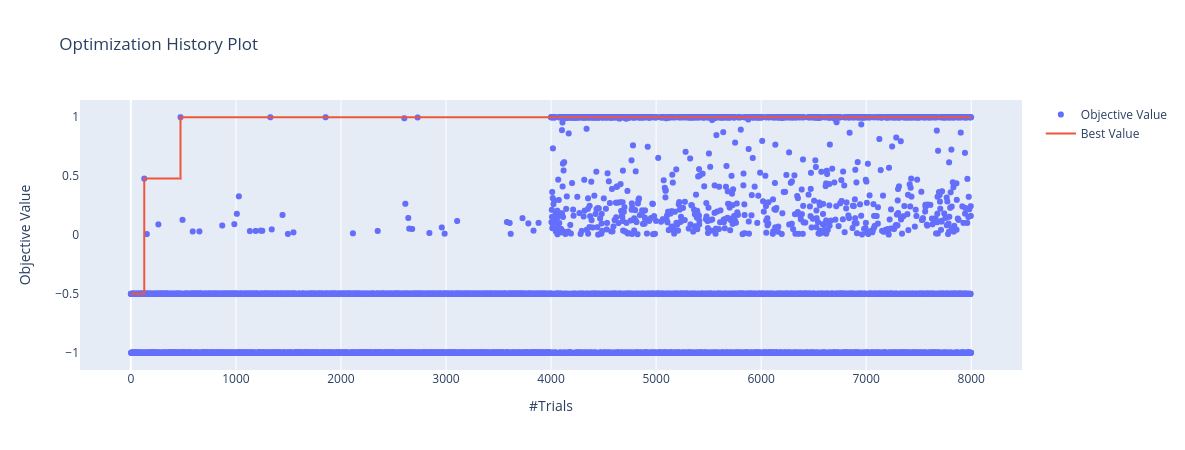

In [95]:
scope = PlotlyScope()
fig = plot_optimization_history(study)
fig.update_yaxes(showgrid=False,zeroline=False,)
# with open("figs/optimization_%s.pdf"%study_name, "wb") as f:
#     f.write(scope.transform(fig, format="pdf", width=800,height=400,))
fig

In [ ]:
scope = PlotlyScope()
fig = plot_optimization_history(study)
fig.update_yaxes(showgrid=False,zeroline=False,)
# with open("figs/optimization_%s.pdf"%study_name, "wb") as f:
#     f.write(scope.transform(fig, format="pdf", width=800,height=400,))
fig

In [480]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_A,params_Amplitude,params_BP Order,params_D,params_High Cut,...,params_Noise Cloud,params_OSC Type,params_R,params_S,params_Start,params_pitch_0,params_pitch_1,params_pitch_2,params_pitch_3,state
0,0,-10.0,2021-08-02 02:37:24.161084,2021-08-02 02:37:24.175922,00:00:00.014838,2,1.0,2,1,81,...,0,0,1,1,9,75,85,47,9,COMPLETE
1,1,-7.0,2021-08-02 02:37:24.162363,2021-08-02 02:37:24.231270,00:00:00.068907,3,1.0,2,1,20,...,1,0,3,0,9,55,1,16,90,COMPLETE
2,2,-7.0,2021-08-02 02:37:24.177468,2021-08-02 02:37:24.246080,00:00:00.068612,1,0.8,1,1,45,...,1,0,3,1,1,70,77,9,54,COMPLETE
3,3,-7.0,2021-08-02 02:37:24.231784,2021-08-02 02:37:24.287795,00:00:00.056011,1,1.0,2,0,97,...,0,0,3,0,1,34,92,111,6,COMPLETE
4,4,-10.0,2021-08-02 02:37:24.246859,2021-08-02 02:37:24.259288,00:00:00.012429,3,0.5,0,0,99,...,0,1,3,1,4,68,103,102,45,COMPLETE
5,5,-7.0,2021-08-02 02:37:24.259827,2021-08-02 02:37:24.321232,00:00:00.061405,1,0.5,2,2,59,...,0,1,3,3,3,77,98,25,92,COMPLETE
6,6,-10.0,2021-08-02 02:37:24.288257,2021-08-02 02:37:24.294297,00:00:00.006040,1,0.5,0,0,113,...,1,2,1,1,1,107,33,22,104,COMPLETE
7,7,-10.0,2021-08-02 02:37:24.294732,2021-08-02 02:37:24.301971,00:00:00.007239,1,0.5,1,3,70,...,0,2,2,2,1,15,14,94,3,COMPLETE
8,8,-7.0,2021-08-02 02:37:24.302431,2021-08-02 02:37:24.341342,00:00:00.038911,1,0.8,1,0,28,...,1,1,0,1,1,45,45,119,68,COMPLETE
9,9,-7.0,2021-08-02 02:37:24.321769,2021-08-02 02:37:24.358564,00:00:00.036795,1,0.5,2,0,12,...,0,2,3,3,3,95,109,2,102,COMPLETE


In [ ]:
scope = PlotlyScope()
fig = plot_slice(study)
fig.update_yaxes(showgrid=False,zeroline=False,)
with open("figs/slice_%s.pdf"%study_name, "wb") as f:
    f.write(scope.transform(fig, format="pdf", width=800,height=400,))
# figz